In [19]:
from PIL import Image # used for loading images
import numpy as np
import os # used for navigating to image path
import imageio # used for writing images
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
import pydot
from timeit import default_timer as timer
from tensorflow.keras import backend as K

from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras.applications import resnet50

In [20]:
def getImageOneHotVector(image_file_name, num_classes=2):
    """Returns one-hot vector encoding for each image for binary or ternary classification"""
    word_label = image_file_name.split('-')[0]
    if num_classes == 2:
        if word_label == 'probable' : 
            return np.array([1, 0])
        elif word_label == 'improbable' : 
            return np.array([0, 1])
        else :
            return np.array([0, 0]) # if label is not present for current image
    elif num_classes == 3:
        if word_label == 'probable' : 
            return np.array([1, 0, 0])
        elif word_label == 'possible' : 
            return np.array([0, 1, 0])    
        elif word_label == 'improbable':
            return np.array([0, 0, 1])
        else :
            return np.array([0, 0, 0]) # if label is not present for current image

In [21]:
#IMG_SIZE = 300
NUM_CLASS = 2
NUM_CHANNEL = 1
DIR = '../../data/tidy/labeled_images_3_classes'
def processImageData(img_size, channels=1, l=400,t=0,r=3424,b=3024):    
    data = []
    image_list = os.listdir(DIR)
    for img in image_list:
        label = getImageOneHotVector(img, NUM_CLASS)
        if label.sum() == 0:
            continue
        path = os.path.join(DIR, img)
        img = Image.open(path)
        if channels == 1:
            img = img.convert('L') # convert image to monochrome 
            img = img.crop((l, t, r, b)) # after cropping, image size is 3024 x 3024 pixels
            #img_size_w, img_size_h = img.size
            img = img.resize((img_size, img_size), Image.BICUBIC)
            data.append([(np.array(img)/255.).T, label])#scale to 0-1 and transpose
#             flip_img = np.fliplr((np.array(img)/255.).T)# Basic Data Augmentation - Horizontal Flipping
#             data.append([flip_img, label])#scale to 0-1 and transpose
        elif channels == 3:
            img = img.crop((l, t, r, b)) # after cropping, image size is 3024 x 3024 pixels  
            img = img.resize((img_size, img_size), Image.BICUBIC)
            data.append([(np.array(img)/255.).T, label])#scale to 0-1 and transpose            
    return (data)

def splitData(image_array, prop = 0.80, seed_num = 111):
    """Returns training and test arrays of images with specified proportion - prop:1-prop"""
    random.Random(seed_num).shuffle(image_array)
    train_size = int(prop*np.shape(image_array)[0])
    train = image_array[:train_size]
    test = image_array[train_size:]
    return(train, test)

In [22]:
processed_image_data = processImageData(108, channels = NUM_CHANNEL)
train_data, test_data = splitData(processed_image_data, seed_num = 111) 

In [23]:
processed_image_data[202][1]

array([0, 1])

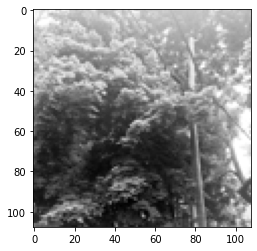

In [24]:
plt.imshow(processed_image_data[202][0], cmap = 'gist_gray')
#plt.savefig( "../../figures/image0.png", dpi=100)

In [25]:
def getImageShape(image_array):
    if NUM_CHANNEL==1:
        image_shape = np.array([np.expand_dims(x[0],axis=2) for x in image_array]).shape[1:4]
    elif NUM_CHANNEL==3:
        image_shape = np.array([x[0] for x in image_array]).shape[1:4][::-1]
    print(image_shape)
    return image_shape

In [26]:
input_image_shape = getImageShape(train_data)

(108, 108, 1)


In [27]:
# Train the model.
if NUM_CHANNEL == 1:
    train_array = np.array([np.expand_dims(x[0],axis=2) for x in train_data])
    validation_array = np.array([np.expand_dims(x[0],axis=2) for x in test_data])
elif NUM_CHANNEL == 3:
    train_array = np.array([x[0] for x in train_data]) 
    train_array = np.moveaxis(train_array, 1, -1)
    validation_array = np.array([x[0] for x in test_data])
    validation_array = np.moveaxis(validation_array, 1, -1)

train_labels = np.array([x[1] for x in train_data])
validation_labels = np.array([x[1] for x in test_data])

In [28]:
len(train_labels)
validation_array.shape
train_array.shape

(302, 108, 108, 1)

In [29]:
#https://github.com/keras-team/keras/issues/5400#issuecomment-408743570
def check_units(y_true, y_pred):
    if y_pred.shape[1] != 1:
      y_pred = y_pred[:,1:2]
      y_true = y_true[:,1:2]
    return y_true, y_pred

def precision(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    y_true, y_pred = check_units(y_true, y_pred)
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [30]:
model = models.Sequential([
    layers.Conv2D(filters = 64, kernel_size = 7, strides = 2, activation="relu", padding="same", input_shape = input_image_shape),
    layers.MaxPooling2D(2),
    layers.Conv2D(128, 3, activation="relu", padding="same"),
    layers.Conv2D(128, 3, activation="relu", padding="same"),
    layers.MaxPooling2D(2),
    layers.Conv2D(256, 3, activation="relu", padding="same"),
    layers.Conv2D(256, 3, activation="relu", padding="same"),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(64, activation="relu"),
    #layers.Dense(64, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASS, activation="softmax")
])

# Compile the model.
opt = SGD(lr = 0.001) #default learning rate (lr) = 0.1
model.compile(loss='categorical_crossentropy',  optimizer = "adam",
              metrics=[precision,recall, f1, 'accuracy'])

In [31]:
start = timer()
model.fit(
    train_array, train_labels, 
    batch_size = 32,
    epochs = 5,
    validation_data=(validation_array, validation_labels)
)
end = timer()
print(end - start) # Time in seconds, e.g. 5.380919524002

Epoch 1/5
10/10 [==============================] - 4s 278ms/step - loss: 0.5677 - precision: 0.9149 - recall: 0.8584 - f1: 0.8652 - accuracy: 0.8023 - val_loss: 0.4920 - val_precision: 0.8021 - val_recall: 1.0000 - val_f1: 0.8892 - val_accuracy: 0.8158
Epoch 2/5
10/10 [==============================] - 2s 236ms/step - loss: 0.5093 - precision: 0.8734 - recall: 0.9912 - f1: 0.9279 - accuracy: 0.8664 - val_loss: 0.4963 - val_precision: 0.8021 - val_recall: 1.0000 - val_f1: 0.8892 - val_accuracy: 0.8158
Epoch 3/5
10/10 [==============================] - 2s 234ms/step - loss: 0.4402 - precision: 0.8611 - recall: 0.9973 - f1: 0.9232 - accuracy: 0.8587 - val_loss: 0.4823 - val_precision: 0.8021 - val_recall: 1.0000 - val_f1: 0.8892 - val_accuracy: 0.8158
Epoch 4/5
10/10 [==============================] - 2s 238ms/step - loss: 0.4322 - precision: 0.8629 - recall: 0.9986 - f1: 0.9252 - accuracy: 0.8625 - val_loss: 0.4867 - val_precision: 0.8021 - val_recall: 1.0000 - val_f1: 0.8892 - val_accur

In [318]:
#loss, acc = model.evaluate(testImages, testLabels, verbose = 0)
#print(acc * 100)
y_pred = model.predict(validation_array, batch_size=32, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(validation_labels, y_pred_bool))

3/3 [==============================] - 0s 59ms/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

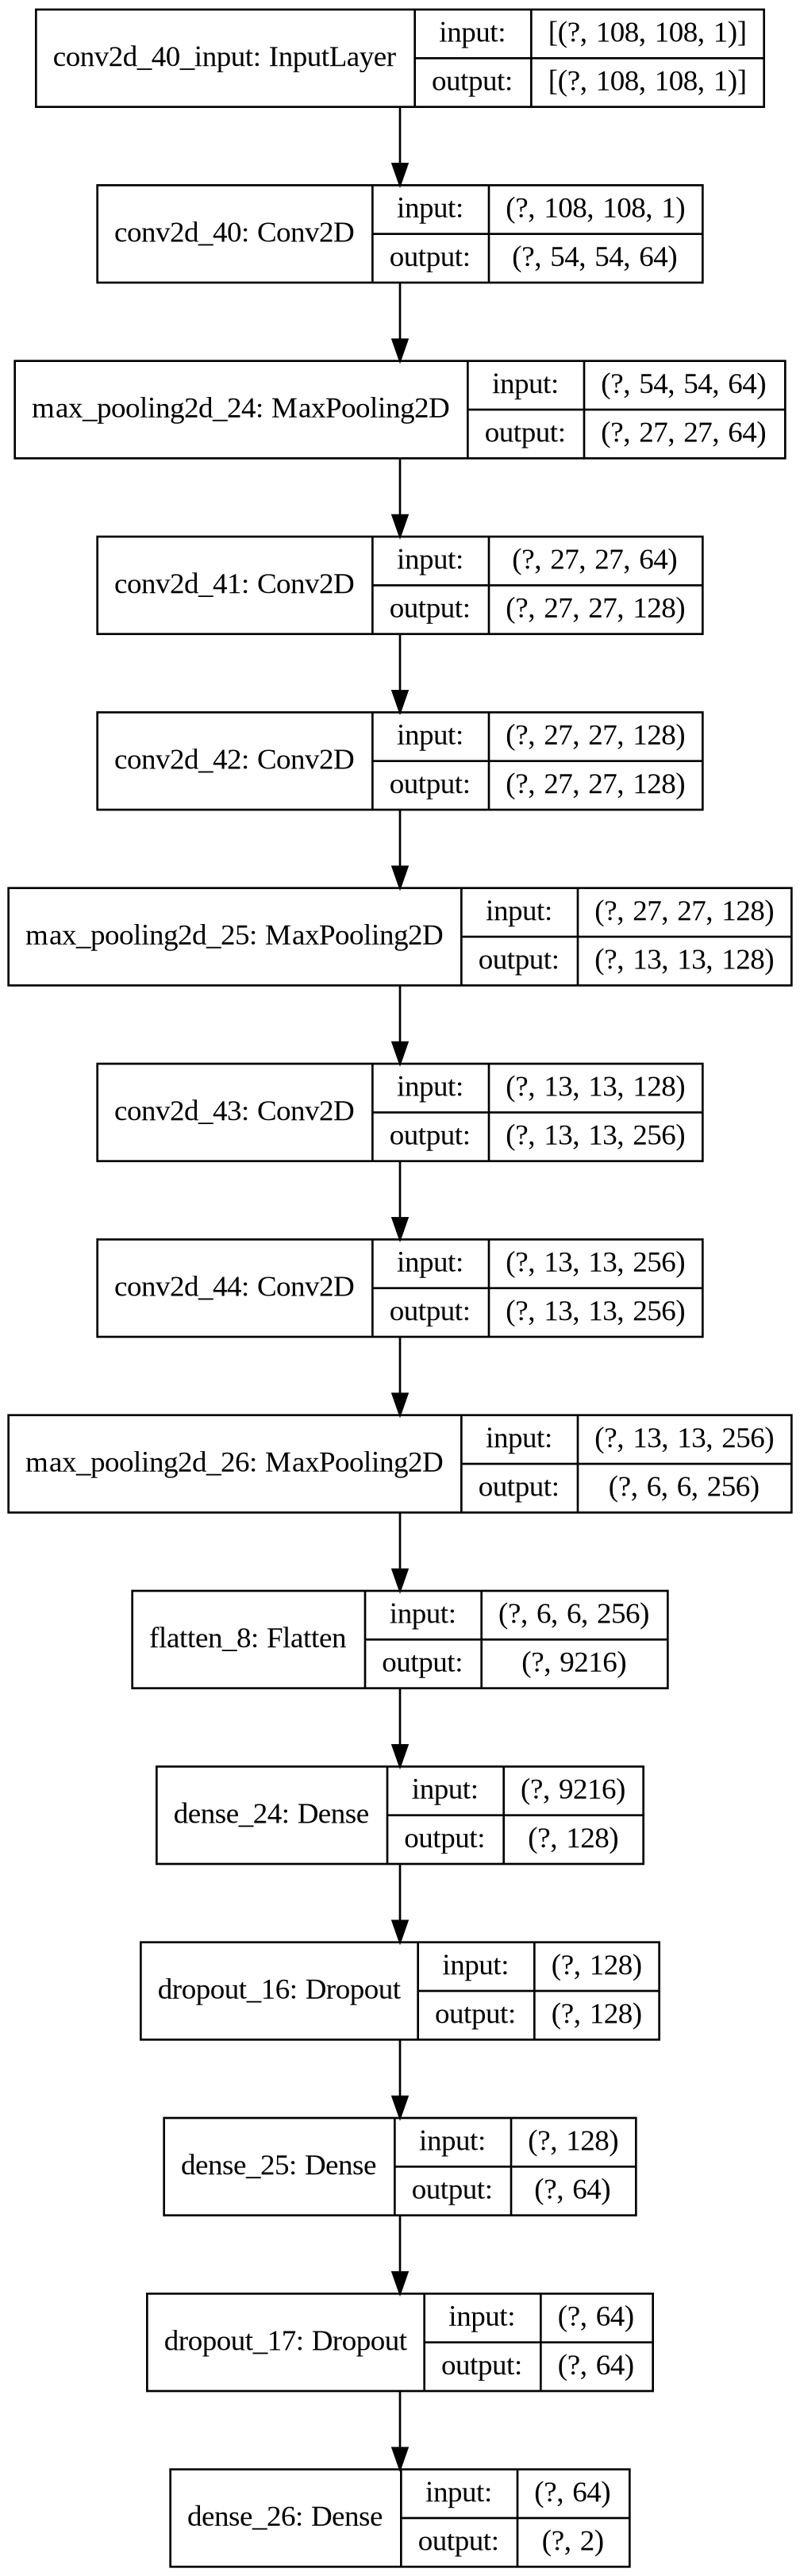

In [59]:
tf.keras.utils.plot_model(model, "../../figures/cnn-model1.png", expand_nested = False, rankdir = "TB", show_shapes=True, dpi=192)

## ResNet

In [194]:
class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            tf.keras.layers.Conv2D(filters, 3, strides=strides, padding="same", use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(filters, 3, strides=1, padding="same", use_bias=False),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                tf.keras.layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias=False),    
                tf.keras.layers.BatchNormalization()
            ]
    
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [319]:
resnet34mod = tf.keras.models.Sequential()
resnet34mod.add(tf.keras.layers.Conv2D(64, 7, strides=2, input_shape=input_image_shape, padding="same", use_bias=False))
resnet34mod.add(tf.keras.layers.BatchNormalization())
resnet34mod.add(tf.keras.layers.Activation("relu"))
resnet34mod.add(tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    resnet34mod.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
resnet34mod.add(tf.keras.layers.GlobalAvgPool2D())
resnet34mod.add(tf.keras.layers.Flatten())
resnet34mod.add(tf.keras.layers.Flatten())
resnet34mod.add(tf.keras.layers.Dense(NUM_CLASS, activation="softmax"))

In [320]:
resnet34mod.compile(loss='binary_crossentropy',  optimizer = "adam",# metrics=[ 'accuracy']) #tf.keras.metrics.SpecificityAtSensitivity(0.5), tf.keras.metrics.SensitivityAtSpecificity(0.5), 
              metrics=[precision,recall, f1, 'accuracy']) #metrics=['accuracy'])

In [321]:
start = timer()
resnet34mod.fit(
    train_array, train_labels, 
    batch_size = 32,
    epochs = 4,
    validation_data=(validation_array, validation_labels)
)
end = timer()
print(end - start) # Time in seconds, e.g. 5.380919524002

Epoch 1/4
10/10 [==============================] - 20s 2s/step - loss: 1.7647 - precision: 0.7503 - recall: 0.7923 - f1: 0.7657 - accuracy: 0.6854 - val_loss: 2.0180 - val_precision: 0.8785 - val_recall: 1.0000 - val_f1: 0.9350 - val_accuracy: 0.8684
Epoch 2/4
10/10 [==============================] - 16s 2s/step - loss: 0.7894 - precision: 0.8551 - recall: 0.9831 - f1: 0.9109 - accuracy: 0.8311 - val_loss: 2.0180 - val_precision: 0.8785 - val_recall: 1.0000 - val_f1: 0.9350 - val_accuracy: 0.8684
Epoch 3/4
10/10 [==============================] - 16s 2s/step - loss: 0.5702 - precision: 0.8443 - recall: 0.9288 - f1: 0.8821 - accuracy: 0.7980 - val_loss: 2.0180 - val_precision: 0.8785 - val_recall: 1.0000 - val_f1: 0.9350 - val_accuracy: 0.8684
Epoch 4/4
10/10 [==============================] - 16s 2s/step - loss: 0.5725 - precision: 0.8482 - recall: 1.0000 - f1: 0.9176 - accuracy: 0.8477 - val_loss: 2.0180 - val_precision: 0.8785 - val_recall: 1.0000 - val_f1: 0.9350 - val_accuracy: 0.8

In [31]:
"Define ResNet 50 model instance (Keras built-in)"
rn50 = resnet50.ResNet50(include_top=True, 
                           weights=None, 
                           input_tensor=None, 
                           input_shape=input_image_shape, 
                           pooling= 'max', 
                           classes=2)

rn50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 108, 108, 1) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 114, 114, 1)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 54, 54, 64)   3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 54, 54, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [32]:
"Configure the model with losses and metrics"
rn50.compile(loss='categorical_crossentropy',  optimizer = "adam",
              metrics=[precision,recall, f1, 'accuracy']) 

start = timer()

"Fit ResNet 50 to data"
rn50.fit(
    train_array, train_labels, 
    batch_size = 32,
    epochs = 5,
    validation_data=(validation_array, validation_labels)
)

end = timer()
print(end - start)

Epoch 1/5
10/10 [==============================] - 26s 2s/step - loss: 2.2389 - precision: 0.7430 - recall: 0.6841 - f1: 0.6807 - accuracy: 0.6315 - val_loss: 0.5447 - val_precision: 0.8021 - val_recall: 1.0000 - val_f1: 0.8892 - val_accuracy: 0.8158
Epoch 2/5
10/10 [==============================] - 20s 2s/step - loss: 0.8596 - precision: 0.8883 - recall: 0.9274 - f1: 0.9011 - accuracy: 0.8331 - val_loss: 8.2311 - val_precision: 0.8021 - val_recall: 1.0000 - val_f1: 0.8892 - val_accuracy: 0.8158
Epoch 3/5
10/10 [==============================] - 20s 2s/step - loss: 0.9014 - precision: 0.8745 - recall: 0.9694 - f1: 0.9162 - accuracy: 0.8511 - val_loss: 14.0406 - val_precision: 0.8021 - val_recall: 1.0000 - val_f1: 0.8892 - val_accuracy: 0.8158
Epoch 4/5
10/10 [==============================] - 20s 2s/step - loss: 0.3899 - precision: 0.9098 - recall: 0.9566 - f1: 0.9298 - accuracy: 0.8774 - val_loss: 4.4512 - val_precision: 0.8021 - val_recall: 1.0000 - val_f1: 0.8892 - val_accuracy: 0.